### Data setup

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

It's a 5
With shape (784,)


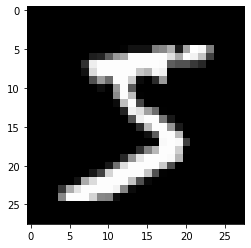

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
print("It's a {}".format(y_train[0]))
print("With shape {}".format(x_train[0].shape))

### Convert data to torch.tensor from numpy array

In [4]:
import torch

x_train, y_train, x_valid, y_valid = x_train.copy(), y_train.copy(), x_valid.copy(), y_valid.copy()
n, c = x_train.shape
print(x_train.dtype)
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
print(x_train.dtype)
print(x_train.max())

float32
torch.float32
tensor(0.9961)


In [5]:
print(x_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## Neural net from scratch (no torch.nn)

In [6]:
#initialize weights
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

print(weights.shape)
print(weights)
print(bias)

torch.Size([784, 10])
tensor([[ 1.4226e-02,  1.6740e-02, -4.9595e-02,  ..., -6.8481e-03,
          8.2001e-04, -1.7930e-02],
        [-4.1257e-02, -3.5172e-02, -5.6507e-02,  ..., -1.0209e-01,
         -2.8609e-02, -9.5295e-03],
        [ 1.5697e-02, -1.5305e-02,  3.5815e-02,  ..., -4.4798e-02,
          5.5595e-03,  1.1760e-02],
        ...,
        [-1.6960e-03, -9.2767e-03, -6.9415e-02,  ...,  3.0212e-02,
         -1.8645e-02, -4.2734e-05],
        [-3.1127e-02,  3.8543e-02, -3.5617e-02,  ..., -7.2380e-02,
          1.5531e-02, -3.1629e-02],
        [-4.4167e-02,  1.1209e-02,  2.0570e-02,  ...,  9.9667e-03,
         -3.2242e-03, -4.2939e-03]], requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [7]:
#activation function

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

#### Preds

In [8]:
batch_size = 64

xb = x_train[:batch_size]
preds = model(xb) #predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2425, -2.3374, -2.7782, -2.0607, -2.7145, -2.3069, -2.4296, -2.3690,
        -1.8692, -2.2441], grad_fn=<SelectBackward>) torch.Size([64, 10])


#### Loss function

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [10]:
yb = y_train[:batch_size]
print(loss_func(preds, yb))

tensor(2.3309, grad_fn=<NegBackward>)


#### Accuracy

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

print(accuracy(preds,yb))

tensor(0.0938)


#### Training loop

In [14]:
from IPython.core.debugger import set_trace

learning_rate = 5e-1
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // batch_size + 1):
        #set_trace()
        start_i = i * batch_size
        end_i = start_i + batch_size
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            weights.grad.zero_()
            bias.grad.zero_()

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0843, grad_fn=<NegBackward>) tensor(1.)


#### Using torch.nn functional 

In [16]:
#loss function with torch.nn.functional as F
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0843, grad_fn=<NllLossBackward>) tensor(1.)


#### NN module

In [19]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()

In [20]:
print(loss_func(model(xb), yb))

tensor(2.3924, grad_fn=<NllLossBackward>)


#### Training loop

In [26]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * learning_rate
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [28]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * learning_rate
                model.zero_grad()

fit()

In [29]:
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


#### Refactor using torch.nn.Linear

In [30]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)
    
model = MnistLogistic()
print(loss_func(model(xb), yb))

tensor(2.3415, grad_fn=<NllLossBackward>)


In [31]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>)


#### Refactor using optim

In [35]:
from torch import optim

def get_model():
    model = MnistLogistic()
    return model, optim.SGD(model.parameters(), lr=learning_rate)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))        

tensor(2.3701, grad_fn=<NllLossBackward>)
tensor(0.0828, grad_fn=<NllLossBackward>)


#### Refactor using Dataset

In [ ]:
from 